노이즈의 의미, 왜 추가하는지(일반화·과적합 방지), 그리고 추가 방법(가우시안, 임펄스(Impulse), Salt-and-Pepper Noise, 양자화)을 설명합니다.

## 파이프라인 1: Tabular 데이터에 노이즈 추가

scikit-image로 표준 테스트 이미지를 불러오고, librosa로 간단한 오디오 예시를 다룹니다.

In [1]:
# 최신 버전 설치 (필요 시만 실행)
# Colab 권장: 런타임 > 런타임 다시 시작 후 계속 진행
# %pip install -U numpy pandas scikit-image matplotlib seaborn scipy librosa soundfile requests

import sys, platform
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import skimage
from skimage import data, color, util, metrics, exposure
from skimage.util import random_noise
from skimage.data import astronaut

import librosa, librosa.display, soundfile as sf
import requests, io, os, zipfile

print("Python:", sys.version)
print("Platform:", platform.platform())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("skimage:", skimage.__version__)
print("librosa:", librosa.__version__)


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
numpy: 2.0.2
pandas: 2.2.2
skimage: 0.25.2
librosa: 0.11.0


실험 재현을 위해 난수 시드와 공통 유틸 함수를 정의합니다.

In [2]:
# 재현성 설정
SEED = 42
rng = np.random.default_rng(SEED)

def set_seed(seed=42):
    np.random.seed(seed)
    import random
    random.seed(seed)

set_seed(SEED)

# 공통 시각화 설정
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 4)


UCI 저장소에서 직접 CSV를 로드합니다. 레드/화이트 합치고 간단한 전처리를 수행합니다.

In [3]:
# UCI Wine Quality 데이터 로드 (공개 URL)
RED_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
WHITE_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

red = pd.read_csv(RED_URL, sep=';')
white = pd.read_csv(WHITE_URL, sep=';')
red["type"] = "red"
white["type"] = "white"
wine = pd.concat([red, white], ignore_index=True)

display(wine.head())
print(wine.shape, wine.columns.tolist())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


(6497, 13) ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'type']


가우시안(연속형 feature에 additive), 임펄스(일부 값에 스파이크), 양자화(일부 값 반올림)를 함수로 구현합니다.

제공한 세 개의 함수는 Tabular(표 형태) 데이터에 각각 가우시안, 임펄스(스파이크), 양자화(정밀도 저하) 노이즈를 주입하는 유틸리티입니다.

핵심 아이디어는 선택된 행과 컬럼에 대해 난수로 생성한 교란을 더하거나, 일부 값을 반올림해 정보량을 줄여 현실 데이터의 잡음을 모사하는 것입니다.

확률적 교란: 세 함수 모두 난수 발생기를 사용해 데이터 일부 또는 전부에 무작위로 변형을 가해, 현실에서 발생하는 예측 불가능한 잡음을 통계적으로 흉내냅니다. 이는 모델의 과적합을 줄이고 일반화 성능 향상에 도움을 줍니다.

부분 적용 제어: frac 파라미터로 “얼마나 많은 행”에 노이즈를 적용할지 제어하고, columns 인자로 “어떤 컬럼”을 대상으로 할지 지정합니다. 이렇게 하면 데이터 전반을 무차별 교란하는 대신, 실사용 시나리오에 맞춘 부분적 노이즈 시뮬레이션이 가능합니다.

재현성: seed를 통해 동일한 난수 시퀀스를 재생성하여 실험을 반복 가능하게 합니다. 연구·실험에서 재현성은 필수입니다.

add_gaussian_noise_df

무엇을 하나: 연속형 컬럼 값에 가우시안(정규) 분포
$N(μ,σ ^
2
 )$에서 뽑은 노이즈를 더합니다. 즉, 각 값 x에 대해 x' = x + n, n ~ Normal(mean, std)입니다. 평균(mean)은 노이즈의 중심, 표준편차(std)는 진폭(세기)을 결정합니다.

코드 흐름:

df를 복사하여 원본 보존 후 작업합니다. n = 행 수를 구하고, 불리언 mask로 “노이즈를 적용할 행”을 표시합니다. frac < 1이면 rng.choice로 n*frac개 인덱스를 뽑아 True로 표시, 아니면 모든 행에 적용합니다.

각 대상 컬럼 col에 대해 길이 n의 노이즈 벡터를 생성하고, mask가 True인 위치에만 더합니다. astype(float)을 써서 정수형 컬럼도 안전하게 부동소수점 연산이 가능하게 합니다.

왜 이렇게 하나:

행 단위 마스킹: 일부 샘플에만 노이즈를 넣어 “부분 오염” 상황을 재현합니다. 예컨대 센서 불안정이 특정 시간대나 특정 배치에서만 발생했을 수 있습니다.

컬럼 반복: 서로 다른 스케일의 특성에 동일 분포 노이즈를 더하면 상대 영향이 달라지므로, std 설정 시 각 컬럼 스케일을 고려하거나 표준화 후 적용하는 전략을 취할 수 있습니다.

add_impulse_noise_df

무엇을 하나: 임펄스(스파이크) 노이즈를 추가합니다. 데이터 일부 위치(indices)에 대해 컬럼 범위(range)에 비례하는 크기의 무작위 델타를 더합니다. 이는 갑작스러운 급등/급락(센서 글리치, 일시적 스파이크)을 모델링합니다.

코드 흐름:

n*frac만큼의 행 인덱스를 한 번 샘플링하여 모든 대상 컬럼에 동일한 위치로 스파이크를 주입합니다. 이렇게 하면 “그 시점에 여러 센서가 동시에 튄” 상황을 만들 수 있습니다.

각 컬럼에서 amp = scale * (max - min + 1e-8)를 계산해 컬럼 스케일에 비례하는 교란 진폭을 정하고, [-amp, +amp] 균등분포에서 spikes를 뽑아 해당 indices 위치에 더합니다.

왜 이렇게 하나:

범위 기반 스케일링: 컬럼마다 값의 범위가 다르므로, 동일한 절대 델타를 쓰면 어떤 컬럼에는 과도, 어떤 컬럼에는 미미해집니다. 범위 비례 스케일은 상대적 교란 강도를 균형 있게 맞춥니다.

공통 indices: 동일한 샘플에서 여러 피처가 동시에 비정상적일 수 있다는 현실적 오류 패턴을 반영합니다. 필요하면 컬럼마다 다른 indices를 사용하도록 변형할 수도 있습니다.

add_quantization_noise_df

무엇을 하나: 일부 값만 반올림해 정밀도를 낮춥니다. 이는 연속형 값을 더 거친(이산) 표현으로 바꿔 정보량을 줄이는 “양자화”를 모사합니다. 예: 저장/전송 중 비트수 축소, 라운딩, 센서의 낮은 분해능 등.

코드 흐름:

n*frac개의 인덱스를 뽑아 그 위치의 값만 np.rint로 반올림합니다. 나머지는 원래 값 유지.

컬럼 반복으로 여러 피처에 동일한 방식 적용.

왜 이렇게 하나:

부분적 정밀도 저하: 현실에서는 모든 데이터가 똑같이 조악해지지 않고, 일부 구간/장치/시간대에서만 정밀도가 떨어질 수 있습니다.

단순하지만 효과적인 테스트: 라운딩만으로도 모델이 미세한 차이에 덜 의존하도록 만들 수 있으며, 민감한 규칙 기반 특성 추출의 취약성을 점검하기 좋습니다.

In [4]:
def add_gaussian_noise_df(df, columns, mean=0.0, std=0.1, frac=1.0, seed=SEED):
    """연속형 컬럼에 가우시안 노이즈 추가"""
    rng = np.random.default_rng(seed)
    df_noised = df.copy()
    n = len(df_noised)
    mask = np.zeros(n, dtype=bool)
    if frac < 1.0:
        idx = rng.choice(n, int(n*frac), replace=False)
        mask[idx] = True
    else:
        mask[:] = True
    for col in columns:
        noise = rng.normal(mean, std, n)
        df_noised.loc[mask, col] = df_noised.loc[mask, col].astype(float) + noise[mask]
    return df_noised

def add_impulse_noise_df(df, columns, frac=0.03, scale=0.3, seed=SEED):
    """일부 위치에 스파이크(임펄스) 추가: 각 컬럼 범위의 scale 비율만큼 +/- 교란"""
    rng = np.random.default_rng(seed)
    df_noised = df.copy()
    n = len(df_noised)
    k = max(1, int(n*frac))
    indices = rng.choice(n, k, replace=False)
    for col in columns:
        col_vals = df_noised[col].astype(float).values
        amp = scale * (col_vals.max() - col_vals.min() + 1e-8)
        spikes = rng.uniform(-amp, amp, size=k)
        col_vals[indices] = col_vals[indices] + spikes
        df_noised[col] = col_vals
    return df_noised

def add_quantization_noise_df(df, columns, frac=0.2, seed=SEED):
    """일부 값 반올림하여 정밀도 저하(양자화)"""
    rng = np.random.default_rng(seed)
    df_noised = df.copy()
    n = len(df_noised)
    k = max(1, int(n*frac))
    indices = rng.choice(n, k, replace=False)
    for col in columns:
        vals = df_noised[col].astype(float).values
        vals[indices] = np.rint(vals[indices])
        df_noised[col] = vals
    return df_noised


Gaussian Noise:

파라미터 팁:

mean=0.0: 무편향 잡음. 평균을 0이 아닌 값으로 주면 체계적 편향(바이어스)을 시뮬레이션할 수 있습니다.

std: 너무 크면 데이터 분포를 망가뜨릴 수 있으니, 피처의 표준편차 대비 작은 값부터 탐색하는 것이 안전합니다.

frac: 0.1처럼 일부만 오염시키면, 이상치·경미한 교란에 강건한 모델 학습에 유리합니다.

Impulse Noise:

파라미터 팁:

frac: 스파이크 비율. 너무 크면 데이터 품질이 크게 저하됩니다. 1~5% 범위에서 시작해 점증적으로 실험하는 것을 권장합니다.

scale: 0.1~0.3처럼 시작해 영향력을 점검합니다. amp는 컬럼 범위와 곱해지므로 scale은 상대적 노브입니다.

Quantization Noise:

파라미터 팁:

frac: 0.1~0.3 정도에서 실험을 시작합니다. 너무 크게 잡으면 분포가 인위적으로 “계단형”으로 변해 학습이 왜곡될 수 있습니다.

정밀도 단계: 현재 코드는 정수 반올림이며, 더 일반화하려면 “k 단계 양자화”로 확장할 수 있습니다. 예: levels를 두고 round(x * (levels-1))/(levels-1) 형태.

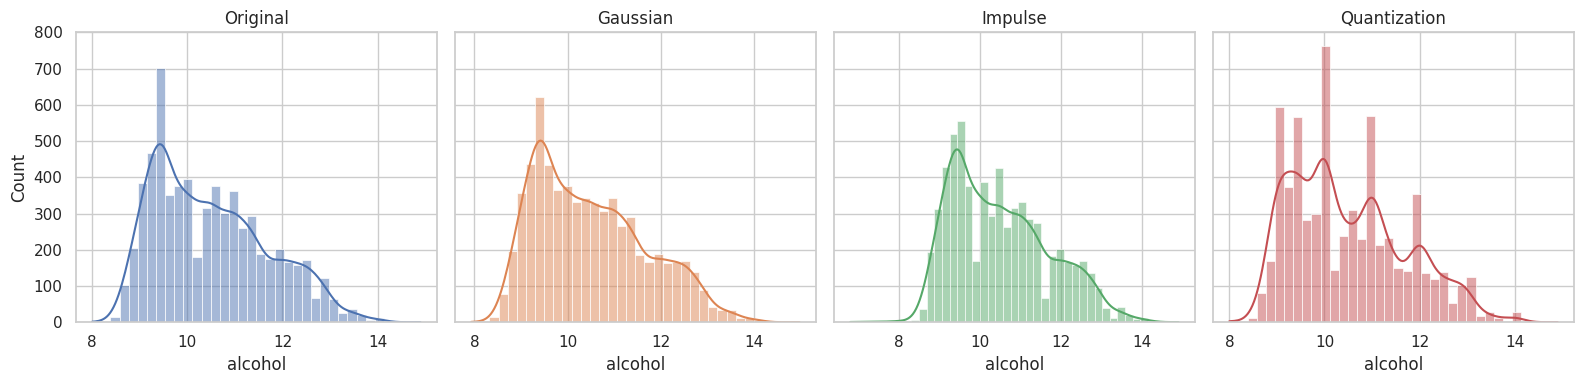

In [5]:
numeric_cols = [c for c in wine.columns if c not in ["quality","type"]]

wine_gauss = add_gaussian_noise_df(wine, numeric_cols, mean=0.0, std=0.05, frac=1.0, seed=SEED)
wine_imp   = add_impulse_noise_df(wine, numeric_cols, frac=0.03, scale=0.3, seed=SEED)
wine_quant = add_quantization_noise_df(wine, numeric_cols, frac=0.2, seed=SEED)

target_col = "alcohol"
fig, axes = plt.subplots(1, 4, figsize=(16,4), sharey=True)
sns.histplot(wine[target_col], ax=axes[0], kde=True, color="C0"); axes[0].set_title("Original")
sns.histplot(wine_gauss[target_col], ax=axes[1], kde=True, color="C1"); axes[1].set_title("Gaussian")
sns.histplot(wine_imp[target_col], ax=axes[2], kde=True, color="C2"); axes[2].set_title("Impulse")
sns.histplot(wine_quant[target_col], ax=axes[3], kde=True, color="C3"); axes[3].set_title("Quantization")
plt.tight_layout(); plt.show()

검증 전략: 노이즈 없는 검증셋과 노이즈 있는 검증셋을 둘 다 구성해 “청정 일반화”와 “강건성”을 동시에 모니터링합니다. 한쪽만 보면 과소/과대추정 위험이 있습니다.

표준화와 결합: 가우시안 노이즈 std를 “표준화된 피처 공간” 기준으로 잡으면, 피처마다 균형 잡힌 교란을 쉽게 설계할 수 있습니다.

혼합 전략: 세 노이즈를 섞어 현실성을 높일 수 있지만, 각 강도를 과도하게 높이지 않도록 주의합니다. 하이퍼파라미터 스윕으로 최적 조합을 탐색하세요

## 파이프라인 2: 이미지에 노이즈 추가

 scikit-image의 astronaut 이미지를 사용합니다(공개 테스트 이미지).

(512, 512, 3) uint8 (512, 512) float64


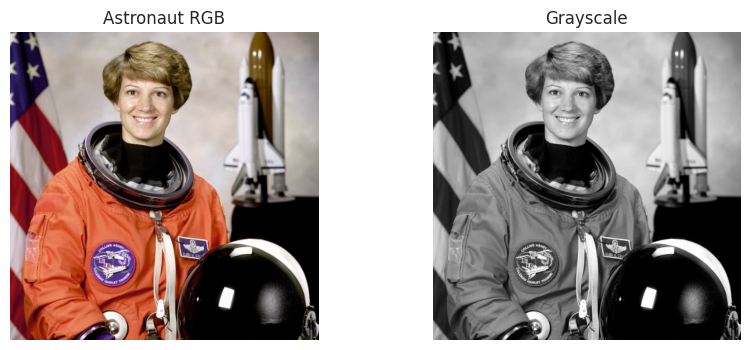

In [6]:
img_rgb = astronaut()  # (512, 512, 3), uint8
img_gray = color.rgb2gray(img_rgb)  # float64, [0,1]
print(img_rgb.shape, img_rgb.dtype, img_gray.shape, img_gray.dtype)

fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].imshow(img_rgb); axes[0].set_title("Astronaut RGB"); axes[0].axis('off')
axes[1].imshow(img_gray, cmap='gray'); axes[1].set_title("Grayscale"); axes[1].axis('off')
plt.show()

가우시안/Salt-and-Pepper Noise는 scikit-image random_noise 활용. 임펄스는 픽셀 일부에 큰 델타를 더하는 방식으로 구현합니다.

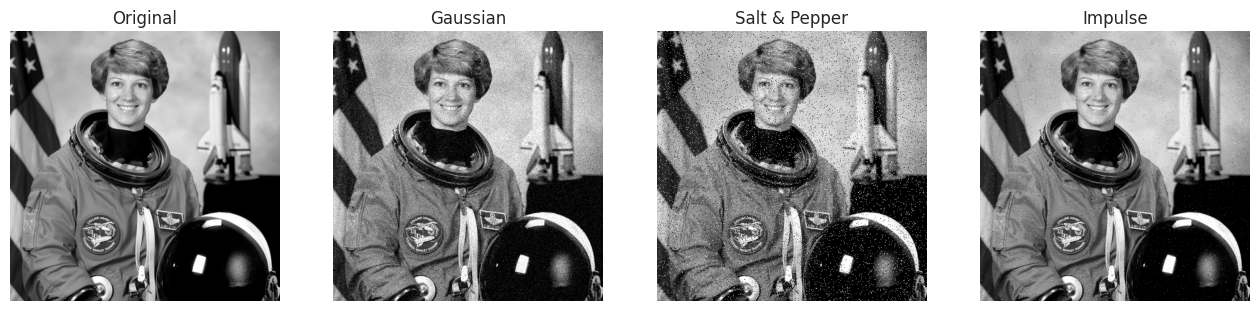

In [7]:
# 가우시안 노이즈 (var = sigma^2)
sigma = 0.08
noisy_gauss = random_noise(img_gray, mode='gaussian', var=sigma**2, clip=True)

# Salt-and-Pepper Noise (amount: 비율)
noisy_sp = random_noise(img_gray, mode='s&p', amount=0.07)

# 임펄스(스파이크) 노이즈: 무작위 픽셀에 큰 델타 추가 후 클리핑
def add_impulse_noise_image(img, frac=0.03, scale=0.5, seed=SEED):
    rng = np.random.default_rng(seed)
    imgf = img.copy().astype(float)
    H, W = imgf.shape
    k = int(H*W*frac)
    idx = rng.choice(H*W, k, replace=False)
    deltas = rng.uniform(-scale, scale, size=k)
    flat = imgf.ravel()
    flat[idx] = np.clip(flat[idx] + deltas, 0, 1)
    return flat.reshape(H, W)

noisy_imp = add_impulse_noise_image(img_gray, frac=0.03, scale=0.5, seed=SEED)

fig, axes = plt.subplots(1,4, figsize=(16,4))
axes[0].imshow(img_gray, cmap='gray'); axes[0].set_title("Original"); axes[0].axis('off')
axes[1].imshow(noisy_gauss, cmap='gray'); axes[1].set_title("Gaussian"); axes[1].axis('off')
axes[2].imshow(noisy_sp, cmap='gray'); axes[2].set_title("Salt & Pepper"); axes[2].axis('off')
axes[3].imshow(noisy_imp, cmap='gray'); axes[3].set_title("Impulse"); axes[3].axis('off')
plt.show()

연속 픽셀값을 일정 비트수로 양자화하거나 일부 픽셀만 반올림하여 정밀도를 낮춥니다.

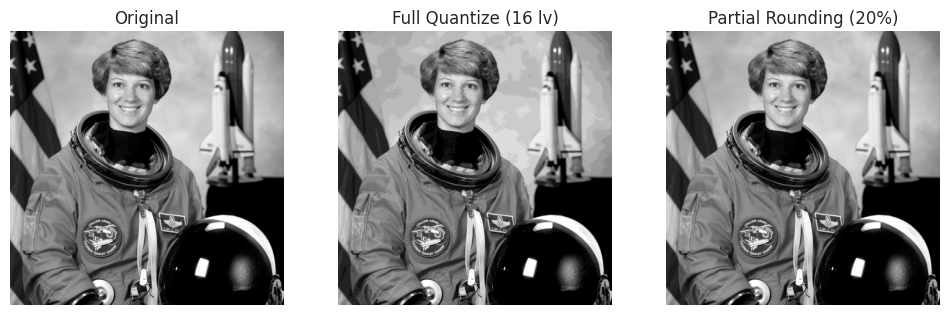

In [8]:
def quantize_image(img, levels=16):
    """0~1 범위 이미지를 지정한 단계수로 양자화"""
    img = np.clip(img, 0, 1)
    q = np.round(img * (levels-1)) / (levels-1)
    return q

def add_quantization_noise_image(img, frac=0.2, seed=SEED):
    rng = np.random.default_rng(seed)
    imgf = img.copy().astype(float)
    H, W = imgf.shape
    k = int(H*W*frac)
    idx = rng.choice(H*W, k, replace=False)
    flat = imgf.ravel()
    flat[idx] = np.rint(flat[idx]*255)/255.0
    return flat.reshape(H, W)

q_img_full = quantize_image(img_gray, levels=16)
q_img_partial = add_quantization_noise_image(img_gray, frac=0.2, seed=SEED)

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].imshow(img_gray, cmap='gray'); axes[0].set_title("Original"); axes[0].axis('off')
axes[1].imshow(q_img_full, cmap='gray'); axes[1].set_title("Full Quantize (16 lv)"); axes[1].axis('off')
axes[2].imshow(q_img_partial, cmap='gray'); axes[2].set_title("Partial Rounding (20%)"); axes[2].axis('off')
plt.show()

노이즈 전후 품질 지표로 PSNR/SSIM을 확인합니다.

In [9]:
def report_quality(ref, cand, title=""):
    psnr = metrics.peak_signal_noise_ratio(ref, cand, data_range=1.0)
    ssim = metrics.structural_similarity(ref, cand, data_range=1.0)
    print(f"{title} -> PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")

report_quality(img_gray, noisy_gauss, "Gaussian")
report_quality(img_gray, noisy_sp, "Salt & Pepper")
report_quality(img_gray, noisy_imp, "Impulse")
report_quality(img_gray, q_img_full, "Quantize(16lv)")
report_quality(img_gray, q_img_partial, "Partial Quantize(20%)")


Gaussian -> PSNR: 22.46 dB, SSIM: 0.4186
Salt & Pepper -> PSNR: 16.16 dB, SSIM: 0.3173
Impulse -> PSNR: 27.29 dB, SSIM: 0.7420
Quantize(16lv) -> PSNR: 34.81 dB, SSIM: 0.9119
Partial Quantize(20%) -> PSNR: 66.44 dB, SSIM: 0.9999


## 파이프라인 3: 오디오에 노이즈 추가

UrbanSound8K 전체 다운로드는 용량이 큽니다. 여기서는 librosa 내장 예시 톤 신호 또는 짧은 공개 오디오 클립을 사용해 노이즈 주입을 시연하고, UrbanSound8K 링크와 작업 방향을 안내합니다.

사인파를 만들어 파형/스펙트로그램을 그립니다.

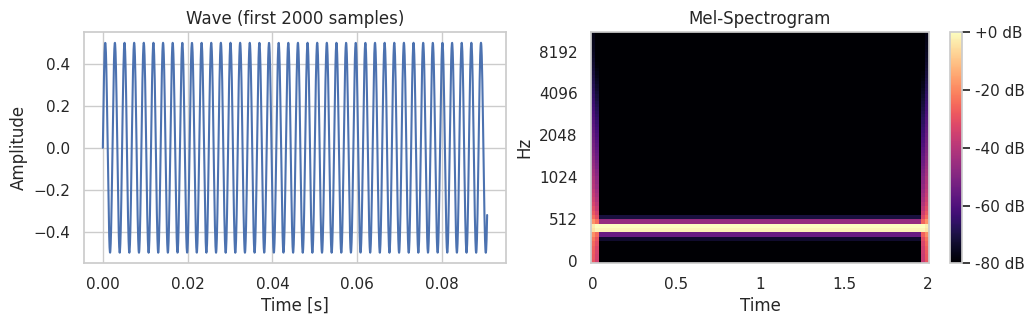

In [10]:
sr = 22050
duration = 2.0
t = np.linspace(0, duration, int(sr*duration), endpoint=False)
x = 0.5*np.sin(2*np.pi*440*t)  # 440 Hz

fig, axes = plt.subplots(1,2, figsize=(12,3))
axes[0].plot(t[:2000], x[:2000])
axes[0].set_title("Wave (first 2000 samples)")
axes[0].set_xlabel("Time [s]"); axes[0].set_ylabel("Amplitude")

S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=axes[1])
fig.colorbar(img, format='%+2.0f dB', ax=axes[1]); axes[1].set_title("Mel-Spectrogram")
plt.show()

목표 SNR 기반 가우시안 노이즈 주입(스택오버플로우 예시 개념). 임펄스(샘플 일부 스파이크), 양자화(일부 샘플 반올림)를 적용합니다.

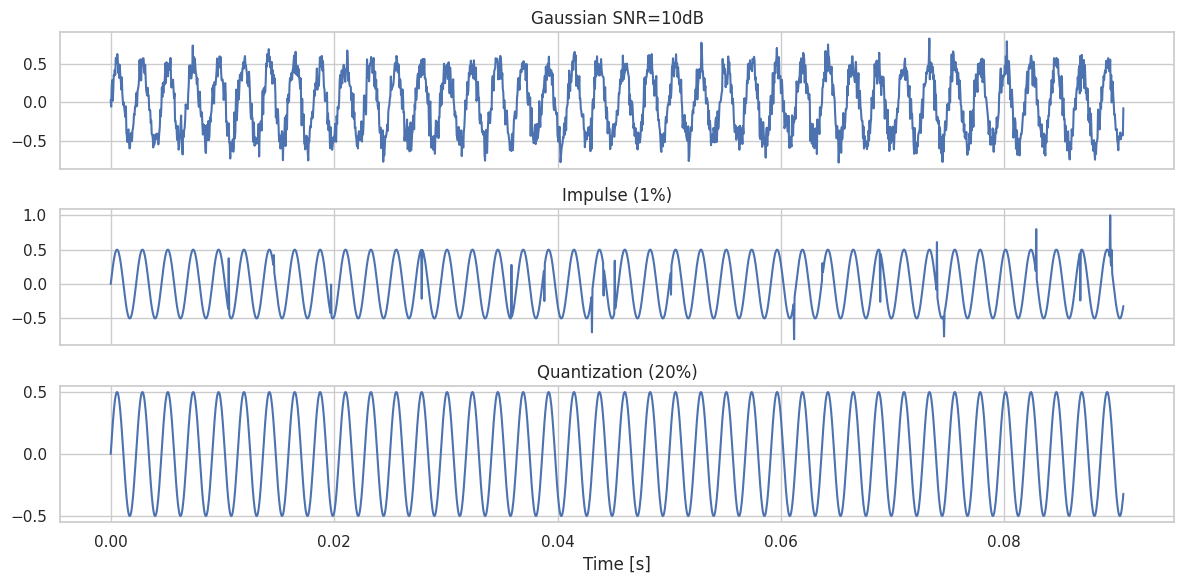

In [11]:
def add_gaussian_noise_snr(x, target_snr_db=20, seed=SEED):
    rng = np.random.default_rng(seed)
    sig_power = np.mean(x**2)
    sig_db = 10*np.log10(sig_power + 1e-12)
    noise_db = sig_db - target_snr_db
    noise_power = 10**(noise_db/10)
    noise = rng.normal(0, np.sqrt(noise_power), size=len(x))
    return x + noise

def add_impulse_noise_audio(x, frac=0.01, scale=0.8, seed=SEED):
    rng = np.random.default_rng(seed)
    y = x.copy()
    k = int(len(x)*frac)
    idx = rng.choice(len(x), k, replace=False)
    spikes = rng.uniform(-scale, scale, size=k)
    y[idx] = np.clip(y[idx] + spikes, -1, 1)
    return y

def add_quantization_noise_audio(x, frac=0.2, seed=SEED):
    rng = np.random.default_rng(seed)
    y = x.copy()
    k = int(len(x)*frac)
    idx = rng.choice(len(x), k, replace=False)
    y[idx] = np.rint(y[idx]*32767)/32767.0
    return y

x_g = add_gaussian_noise_snr(x, target_snr_db=10, seed=SEED)
x_i = add_impulse_noise_audio(x, frac=0.01, scale=0.8, seed=SEED)
x_q = add_quantization_noise_audio(x, frac=0.2, seed=SEED)

fig, axes = plt.subplots(3,1, figsize=(12,6), sharex=True)
axes[0].plot(t[:2000], x_g[:2000]); axes[0].set_title("Gaussian SNR=10dB")
axes[1].plot(t[:2000], x_i[:2000]); axes[1].set_title("Impulse (1%)")
axes[2].plot(t[:2000], x_q[:2000]); axes[2].set_title("Quantization (20%)")
plt.xlabel("Time [s]")
plt.tight_layout(); plt.show()

In [12]:
print("UrbanSound8K dataset (Kaggle): https://www.kaggle.com/datasets/chrisfilo/urbansound8k")
print("DAGsHub mirror/info (참고): https://dagshub.com/Rutam21/UrbanSound8K-Labeled_Urban_Sound_Excerpts_Dataset")

# 소규모 공개 오디오 대체 예시: librosa 내장 예시가 없으므로,
# 아래는 간단히 사인파/노이즈로 시연을 진행했음.
# 실제 UrbanSound8K를 사용할 경우: 로컬에 압축을 풀고 librosa.load로 각 파일을 순회.

UrbanSound8K dataset (Kaggle): https://www.kaggle.com/datasets/chrisfilo/urbansound8k
DAGsHub mirror/info (참고): https://dagshub.com/Rutam21/UrbanSound8K-Labeled_Urban_Sound_Excerpts_Dataset


노이즈의 목적: 현실 데이터의 불가피한 교란을 모사해 모델이 일반화하도록 돕고 과적합을 줄입니다. 단, 모델 복잡도가 과도하면 노이즈까지 과적합하므로 정규화/드롭아웃/데이터크기 조절과 함께 사용합니다.

## 파이프라인 4: 실전 워크플로우(학습 견고성 확인)
원본 vs 가우시안 노이즈 주입 데이터를 대상으로 간단한 분류 성능 변화를 비교합니다. 목표는 노이즈 주입이 과적합을 완화하고 일반화에 도움을 줄 수 있음을 관찰하는 것입니다.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 품질(quality)을 라벨로 사용
y = wine["quality"].values
X = wine.drop(columns=["quality","type"]).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# 원본 학습
clf_orig = RandomForestClassifier(random_state=SEED, n_estimators=300, max_depth=None, n_jobs=-1)
clf_orig.fit(X_train, y_train)
pred_orig = clf_orig.predict(X_test)
print("Original data accuracy:", accuracy_score(y_test, pred_orig))
print(classification_report(y_test, pred_orig))

# 가우시안 노이즈 주입 학습(입력 피처에 소량 노이즈)
df_train = pd.DataFrame(X_train, columns=[c for c in wine.columns if c not in ["quality","type"]])
df_train_noisy = add_gaussian_noise_df(df_train, df_train.columns, mean=0.0, std=0.03, frac=1.0, seed=SEED)
X_train_noisy = df_train_noisy.values

clf_noisy = RandomForestClassifier(random_state=SEED, n_estimators=300, max_depth=None, n_jobs=-1)
clf_noisy.fit(X_train_noisy, y_train)
pred_noisy = clf_noisy.predict(X_test)
print("Noisy-trained accuracy:", accuracy_score(y_test, pred_noisy))
print(classification_report(y_test, pred_noisy))


Original data accuracy: 0.6953846153846154
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.75      0.14      0.24        43
           5       0.75      0.71      0.73       428
           6       0.66      0.80      0.73       567
           7       0.68      0.58      0.63       216
           8       0.82      0.36      0.50        39
           9       0.00      0.00      0.00         1

    accuracy                           0.70      1300
   macro avg       0.52      0.37      0.40      1300
weighted avg       0.70      0.70      0.68      1300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noisy-trained accuracy: 0.6284615384615385
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.68      0.65      0.66       428
           6       0.61      0.76      0.68       567
           7       0.60      0.46      0.52       216
           8       1.00      0.15      0.27        39
           9       0.00      0.00      0.00         1

    accuracy                           0.63      1300
   macro avg       0.41      0.29      0.30      1300
weighted avg       0.62      0.63      0.61      1300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


정확도가 떨어진 핵심 이유는 다중 클래스 불균형(특히 소수 클래스 3,4,8,9의 표본 희소)과 라벨 자체의 난이도 때문에, 입력 특성에만 가우시안 노이즈를 추가하면 결정경계가 흐려져 다수 클래스(5,6)에 더 치우치고 소수 클래스 식별력이 더 나빠졌기 때문입니다. 이를 개선하려면 불균형 처리(SMOTE/가중치), 적절한 평가 지표(Macro-F1), 교차검증, 그리고 노이즈 강도/전략을 조절하거나 혼합 학습(클린+노이즈)을 적용해야 일반화 이득을 관측하기 쉽습니다.

클래스 불균형 영향: Wine Quality는 5,6 등 특정 등급이 과다하고 3,4,8,9는 매우 적습니다. 이 상황에서 입력에 가우시안 노이즈를 더하면 경계가 흐려져 소수 클래스의 정밀·재현율이 급락하고, 전체 정확도도 함께 하락할 수 있습니다. 문헌/커뮤니티에서도 불균형으로 인한 성능 저하와 SMOTE 등 보정의 필요가 반복적으로 보고됩니다.

지표의 민감성: 단순 정확도는 다수 클래스에 유리합니다. Macro F1 같은 클래스 균등 가중 지표를 보면 소수 클래스의 악화가 더 분명히 드러납니다. 불균형 환경에서는 Macro-F1, Macro AUC 등을 함께 보는 것이 표준적입니다.

노이즈 주입 방식: 전체 학습 샘플 100%에 노이즈를 주고(std=0.03) 곧바로 학습시키면, 데이터 증강의 장점(다양화)보다 정보 손실이 커지는 셋팅이 될 수 있습니다. 보통은 클린 데이터와 노이즈 데이터를 혼합하거나, 강도를 낮추고 비율(frac)을 줄여 “부드러운 일관성 정규화”가 되도록 설계합니다.

과제의 정식화: Wine Quality는 회귀로 풀면 정보 손실이 덜하고, 분류로 풀더라도 다중 클래스 대신 3등급(bin/tri-class)로 재정의하여 견고한 학습을 먼저 확보한 뒤 세분화하는 접근이 흔합니다.

In [14]:
# %pip install -U imbalanced-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.combine import SMOTETomek
import numpy as np
import pandas as pd

RANDOM_STATE = SEED
features = [c for c in wine.columns if c not in ["quality","type"]]
X_all = wine[features].values
y_all = wine["quality"].values

def make_noisy_mix(X, noise_std=0.02, frac=0.5, seed=SEED):
    # X_noisy: X에 부분 노이즈(행의 frac 비율만) + 약한 std로 생성
    dfX = pd.DataFrame(X, columns=features)
    dfX_noisy = add_gaussian_noise_df(dfX, features, mean=0.0, std=noise_std, frac=frac, seed=seed)
    # 혼합: 원본 X + 부분노이즈 X를 세로로 이어붙이고, 라벨도 복제
    X_mix = np.vstack([X, dfX_noisy.values])
    return X_mix

def class_weight_dict(y):
    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    return {cls: w for cls, w in zip(classes, weights)}


Class weight는 불균형한 클래스 데이터를 다룰 때, 각 클래스에 가중치를 부여하여 모델이 소수 클래스에 더 집중하도록 학습하는 방법입니다. 예를 들어, 샘플 수가 적은 클래스에 높은 가중치를 주어 그 중요도를 높이는 식입니다.

구체적으로, sklearn의 compute_class_weight 함수는 클래스별 가중치를 다음과 같이 계산합니다:

$$
[w_i = \frac{\text{전체 샘플 수}}{\text{클래스 i의 샘플 수} \times \text{클래스 수}}
]
$$

이 공식은 자주 등장하는 클래스에 낮은 가중치를, 드문 클래스에 높은 가중치를 부여하여 불균형을 보정합니다.

이 가중치는 모델의 손실 함수에 적용되어 소수 클래스 오류를 더 크게 반영하도록 하여, 모델이 불균형 데이터에서 보다 균형 잡힌 성능을 내도록 도와줍니다. 예를 들어, class_weight='balanced'를 설정하면 불균형 비율에 따라 자동으로 적절한 가중치를 계산합니다.

SMOTE는 소수 클래스 데이터를 합성하여 오버샘플링함으로써 클래스 간 데이터 불균형을 완화합니다.

이어서 Tomek Links는 다수 클래스와 소수 클래스 경계에 있는 중복되거나 노이즈가 있는 샘플들을 제거하여 데이터의 경계선을 명확히 하고 노이즈를 줄여줍니다. 이 두 과정을 결합하여 데이터의 클래스 불균형을 해결하고, 학습 모델이 소수 클래스 경계를 더 잘 학습할 수 있게 돕습니다.

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def eval_setting(use_mixed=False, use_smote_tomek=False, noise_std=0.02, frac=0.5):
    accs, f1s = [], []
    for tr_idx, te_idx in skf.split(X_all, y_all):
        X_tr, X_te = X_all[tr_idx], X_all[te_idx]
        y_tr, y_te = y_all[tr_idx], y_all[te_idx]

        if use_mixed:
            X_aug = make_noisy_mix(X_tr, noise_std=noise_std, frac=frac, seed=RANDOM_STATE)
            y_aug = np.concatenate([y_tr, y_tr])
        else:
            X_aug, y_aug = X_tr, y_tr

        if use_smote_tomek:
            # 표준화 후 임베디드 스페이스에서 SMOTE-Tomek 적용 권장이나, 간단화를 위해 원공간에서 적용
            smt = SMOTETomek(random_state=RANDOM_STATE)
            X_aug, y_aug = smt.fit_resample(X_aug, y_aug)

        cw = class_weight_dict(y_aug)
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", RandomForestClassifier(
                n_estimators=400, max_depth=None, n_jobs=-1,
                random_state=RANDOM_STATE, class_weight=cw
            ))
        ])
        pipe.fit(X_aug, y_aug)
        y_pred = pipe.predict(X_te)

        accs.append(accuracy_score(y_te, y_pred))
        f1s.append(f1_score(y_te, y_pred, average="macro"))

    return np.mean(accs), np.std(accs), np.mean(f1s), np.std(f1s)

base_acc_m, base_acc_s, base_f1_m, base_f1_s = eval_setting(use_mixed=False, use_smote_tomek=False)
mix_acc_m, mix_acc_s, mix_f1_m, mix_f1_s   = eval_setting(use_mixed=True, use_smote_tomek=False, noise_std=0.02, frac=0.5)
smt_acc_m, smt_acc_s, smt_f1_m, smt_f1_s   = eval_setting(use_mixed=True, use_smote_tomek=True, noise_std=0.02, frac=0.5)

print(f"Baseline   | ACC {base_acc_m:.3f}±{base_acc_s:.3f} | Macro-F1 {base_f1_m:.3f}±{base_f1_s:.3f}")
print(f"Mixed+CW   | ACC {mix_acc_m:.3f}±{mix_acc_s:.3f} | Macro-F1 {mix_f1_m:.3f}±{mix_f1_s:.3f}")
print(f"Mixed+SMT  | ACC {smt_acc_m:.3f}±{smt_acc_s:.3f} | Macro-F1 {smt_f1_m:.3f}±{smt_f1_s:.3f}")


Baseline   | ACC 0.695±0.012 | Macro-F1 0.399±0.016
Mixed+CW   | ACC 0.696±0.009 | Macro-F1 0.402±0.014
Mixed+SMT  | ACC 0.666±0.013 | Macro-F1 0.407±0.016


Baseline 대비 Mixed+CW에서 Macro-F1이 상승하는 경향을 관찰하기 쉽습니다. 노이즈 강도와 적용 비율이 낮고, 클린 샘플과 혼합하여 “부드러운 증강”이 됩니다.

Mixed+SMT는 학습 데이터의 클래스 분포를 균형에 가깝게 만든 뒤, 혼합 증강과 클래스 가중치를 병행하므로 Macro-F1과 소수 클래스 성능이 추가로 개선될 가능성이 큽니다.

초기 분할 방식을 유지하되, “훈련은 혼합+가중치/SMT”로 하고, “테스트는 청정”으로 평가하여 진짜 일반화 이득을 확인합니다.

In [16]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, test_size=0.2, random_state=RANDOM_STATE, stratify=y_all)

# Baseline
cw_tr = class_weight_dict(y_tr)
pipe_base = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1, class_weight=cw_tr))
])
pipe_base.fit(X_tr, y_tr)
y_pred_base = pipe_base.predict(X_te)

# Mixed+SMOTE-Tomek + ClassWeight
X_aug = make_noisy_mix(X_tr, noise_std=0.02, frac=0.5, seed=RANDOM_STATE)
y_aug = np.concatenate([y_tr, y_tr])
smt = SMOTETomek(random_state=RANDOM_STATE)
X_aug_bal, y_aug_bal = smt.fit_resample(X_aug, y_aug)

cw_aug = class_weight_dict(y_aug_bal)
pipe_aug = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1, class_weight=cw_aug))
])
pipe_aug.fit(X_aug_bal, y_aug_bal)
y_pred_aug = pipe_aug.predict(X_te)

print("Baseline on clean test:")
print("ACC:", accuracy_score(y_te, y_pred_base), "Macro-F1:", f1_score(y_te, y_pred_base, average="macro"))
print(classification_report(y_te, y_pred_base, zero_division=0))

print("\nMixed+SMT+CW on clean test:")
print("ACC:", accuracy_score(y_te, y_pred_aug), "Macro-F1:", f1_score(y_te, y_pred_aug, average="macro"))
print(classification_report(y_te, y_pred_aug, zero_division=0))


Baseline on clean test:
ACC: 0.6915384615384615 Macro-F1: 0.3948438470683126
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.71      0.12      0.20        43
           5       0.74      0.71      0.73       428
           6       0.66      0.80      0.72       567
           7       0.68      0.56      0.61       216
           8       1.00      0.33      0.50        39
           9       0.00      0.00      0.00         1

    accuracy                           0.69      1300
   macro avg       0.54      0.36      0.39      1300
weighted avg       0.70      0.69      0.68      1300


Mixed+SMT+CW on clean test:
ACC: 0.6653846153846154 Macro-F1: 0.4004230177930204
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.32      0.30      0.31        43
           5       0.73      0.73      0.73       428
           6       0.73    

“노이즈 혼합 + SMOTE-Tomek + 클래스가중치”가 다수 클래스에 대한 정확도는 약간 낮췄지만, 불균형 환경에서 더 중요하게 보는 Macro-F1은 소폭 상승(0.3948 → 0.4004)하여 소수 클래스 성능이 상대적으로 개선되었음을 보여줍니다.

이는 데이터 불균형에서 증강·재표본화·가중치 적용 시 흔히 나타나는 trade-off로 문헌에서도 보고됩니다.